# 1. Initializations and Dataset Download

In [1]:
!pip install kaggle wandb onnx -Uq
from google.colab import drive
drive.mount('/content/drive')

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.2/23.2 MB 31.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.6/17.6 MB 24.9 MB/s eta 0:00:00
Mounted at /content/drive


In [2]:
! mkdir ~/.kaggle

In [3]:
!cp /content/drive/MyDrive/ML/kaggle/kaggle.json ~/.kaggle/kaggle.json

In [4]:
! chmod 600 ~/.kaggle/kaggle.json

In [5]:
! kaggle competitions download -c challenges-in-representation-learning-facial-expression-recognition-challenge

 94% 268M/285M [00:03<00:00, 54.3MB/s]
100% 285M/285M [00:03<00:00, 79.4MB/s]


In [6]:
! unzip challenges-in-representation-learning-facial-expression-recognition-challenge.zip -d facial-expression-recognition-dataset

Archive:  challenges-in-representation-learning-facial-expression-recognition-challenge.zip
  inflating: facial-expression-recognition-dataset/example_submission.csv  
  inflating: facial-expression-recognition-dataset/fer2013.tar.gz  
  inflating: facial-expression-recognition-dataset/icml_face_data.csv  
  inflating: facial-expression-recognition-dataset/test.csv  
  inflating: facial-expression-recognition-dataset/train.csv  


Now I should have directory `facial-expression-recognition-dataset` containing dataset files from kaggle

# 2. Imports
Lets start by getting all our imports, keep in mind that PyTorch is not automatically detects and trains on GPU, you have to tell it to use cuda. In case you want to train on Mac Silicon replace cuda with mps.

In [36]:
import torch # Main PyTorch Library
from torch import nn # Used for creating the layers and loss function
from torch.optim import Adam # Adam Optimizer
import torchvision.transforms as transforms # Transform function used to modify and preprocess all the images
from torch.utils.data import Dataset, DataLoader # Dataset class and DataLoader for creating the objects
from sklearn.preprocessing import LabelEncoder # Label Encoder to encode the classes from strings to numbers
from sklearn.model_selection import train_test_split # Train/Test split
import matplotlib.pyplot as plt # Used for visualizing the images and plotting the training progress
from PIL import Image # Used to read the images from the directory
import pandas as pd # Used to read/create dataframes (csv) and process tabular data
import numpy as np # preprocessing and numerical/mathematical operations
import os # Used to read the images path from the directory

device = "cuda" if torch.cuda.is_available() else "cpu" # detect the GPU if any, if not use CPU, change cuda to mps if you have a mac
print("Device available: ", device)

Device available:  cpu


# 3. Data Exploration

### 3.1 Data Loading

In [13]:
train_df = pd.read_csv('facial-expression-recognition-dataset/train.csv')
test_df = pd.read_csv('facial-expression-recognition-dataset/test.csv')

print(f"trainset shape: {train_df.shape}")
print(f"testset shape: {test_df.shape}")
print(f"\nEmotion distribution in trainset:")
print(train_df['emotion'].value_counts().sort_values(ascending=False))

emotion_labels = {0: 'Angry', 1: 'Disgust', 2: 'Fear', 3: 'Happy', 4: 'Sad', 5: 'Surprise', 6: 'Neutral'}

trainset shape: (28709, 2)
testset shape: (7178, 1)

Emotion distribution in trainset:
emotion
3    7215
6    4965
4    4830
2    4097
0    3995
5    3171
1     436
Name: count, dtype: int64


### 3.2 Data Inspection

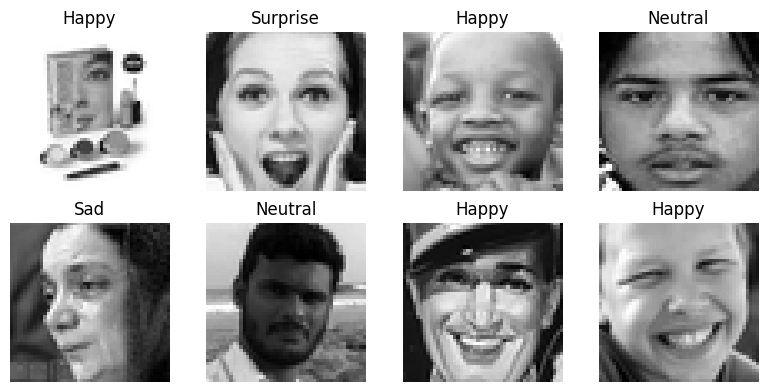

In [34]:
def plot_sample_images(df, num_samples=8):
    _, axes = plt.subplots(2, 4, figsize=(8, 4))
    axes = axes.ravel()

    for i in range(num_samples):
        # random sample
        idx = np.random.randint(0, len(df))
        emotion = df.iloc[idx]['emotion']
        pixels = df.iloc[idx]['pixels']

        # convert bytearray to grayscale image
        pixel_values = np.array(pixels.split(), dtype=np.uint8)
        image = pixel_values.reshape(48, 48)

        axes[i].imshow(image, cmap='gray')
        axes[i].set_title(f'{emotion_labels[emotion]}')
        axes[i].axis('off')

    plt.tight_layout()
    plt.show()

plot_sample_images(train_df)

### 3.3 Custom Dataset Class

In [35]:
class FERDataset(Dataset):
    def __init__(self, dataframe, transform=None, is_test=False):
        self.dataframe = dataframe
        self.transform = transform
        self.is_test = is_test

    def __len__(self):
        return self.dataframe.shape[0]

    def __getitem__(self, idx):
        pixels = self.dataframe.iloc[idx, 1]
        pixel_values = np.array(pixels.split(), dtype=np.float32)
        image = pixel_values.reshape(48, 48, 1) # add channel
        image = Image.fromarray(image.squeeze(), mode='L') # convert to PIL image

        if self.transform:
            image = self.transform(image).to(device)

        if not self.is_test:
            emotion = self.dataframe.iloc[idx, 0]
            return image, emotion
        else:
            return image

### 3.4 Data Transforms and Data Loaders

In [37]:
train_transform_chain = transforms.Compose([
    transforms.RandomHorizontalFlip(p=0.5), # randomly flip horizontally, try to maintain symmetry between turned faces
    transforms.RandomRotation(degrees=10), # randomly rotate with -10/+10 degrees, try to maintain symmetry between tilted faces
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5])
])

val_transform_chain = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5])
])

# train/test split
train_data, val_data = train_test_split(train_df, test_size=0.2, random_state=42, stratify=train_df['emotion']) # stratify on emotion to maintain class balance

# create datasets
train_dataset = FERDataset(train_data.reset_index(drop=True), transform=train_transform_chain)
val_dataset = FERDataset(val_data.reset_index(drop=True), transform=val_transform_chain)
test_dataset = FERDataset(test_df, transform=val_transform_chain, is_test=True)
